<a href="https://colab.research.google.com/github/Venura-Shiromal/NASA-Space-Apps-2025/blob/main/TESS/TOI_ClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# just in case if needed
#!pip install catboost
#!pip install pandas
#!pip install numpy
#!pip install scikit-learn
#!pip install matplotlib
#!pip install seaborn

## Prerequisities

In [62]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data

In [82]:
toi = pd.read_csv('TOI_Data.csv', comment='#')

## Feature Selection

In [83]:
features = [
    "tfopwg_disp",
    "pl_orbper",
    "pl_trandurh",
    "pl_trandep",
    "pl_rade",
    "pl_insol",
    "pl_eqt",
    "st_tmag",
    "st_dist",
    "st_teff",
    "st_rad",
    "st_logg"
]

drop_list = [
    "toi", "tid",
    "rastr", "ra", "decstr", "dec",
    "st_pmra", "st_pmraerr1", "st_pmraerr2", "st_pmralim",
    "st_pmdec", "st_pmdecerr1", "st_pmdecerr2", "st_pmdeclim",
    "pl_tranmid", "pl_tranmiderr1", "pl_tranmiderr2", "pl_tranmidlim",
    "pl_orbpererr1", "pl_orbpererr2", "pl_orbperlim",
    "pl_trandurherr1", "pl_trandurherr2", "pl_trandurhlim",
    "pl_trandeperr1", "pl_trandeperr2", "pl_trandeplim",
    "pl_radelim",
    "st_tmagerr1", "st_tmagerr2", "st_tmaglim",
    "st_disterr1", "st_disterr2", "st_distlim",
    "st_tefferr1", "st_tefferr2", "st_tefflim",
    "st_logglim",
    "st_radlim",
    "toi_created", "rowupdate",

    # Missing Data
    "pl_radeerr1", "pl_radeerr2",
    "pl_insolerr1", "pl_insolerr2", "pl_insollim",
    "pl_eqterr1", "pl_eqterr2", "pl_eqtlim",
    "st_loggerr1", "st_loggerr2",
    "st_raderr1", "st_raderr2"
]


In [84]:
toi = toi[features]

Label Mapping

In [85]:
label_map = {
    "CP": 1,   # Confirmed Planet
    "KP": 1,   # Known Planet
    "PC": 0,   # Planetary Candidate
    "APC": 0,  # Ambiguous Planetary Candidate
    "FP": -1,  # False Positive
    "FA": -1   # False Alarm
}

toi["tfopwg_disp"] = toi["tfopwg_disp"].map(label_map)

## Filling empty cells

In [86]:
for col in features:
    toi[col].fillna(toi[col].median(), inplace=True)

/tmp/ipython-input-1020813461.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  toi[col].fillna(toi[col].median(), inplace=True)


### Diagnoise

In [68]:
#print(toi.isna().sum()[toi.isna().sum() > 0])
#for col in features:
#    print(toi[col].dtype)

## Defining data sets

In [87]:
X = toi.drop("tfopwg_disp", axis=1)
y = toi["tfopwg_disp"]

In [88]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
    )

Defining Classes

In [89]:
classes = np.unique(y_train)

Calculating Class Weights

In [90]:
weights = compute_class_weight("balanced", classes=classes, y=y_train)

Combining both

In [91]:
class_weights = dict(zip(classes, weights))

### Cross-validation

In [92]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, valid_idx in skf.split(X, y):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

## Cat Boost Initiation

### Parameters


In [104]:
max_ite = 5000
dep = 8
l_rate = 0.04

In [105]:
model = CatBoostClassifier(
    iterations=max_ite,
    depth=dep,
    learning_rate=l_rate,
    loss_function="MultiClass",
    eval_metric="MultiClass",
    l2_leaf_reg=7,
    border_count=1024,
    early_stopping_rounds=50,
    random_seed=42,
    verbose=50,
    class_weights=class_weights
)


# Training

In [106]:
model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 1.0849149	test: 1.0849105	best: 1.0849105 (0)	total: 80.8ms	remaining: 6m 43s
50:	learn: 0.8298330	test: 0.8348135	best: 0.8348135 (50)	total: 5.04s	remaining: 8m 9s
100:	learn: 0.7565985	test: 0.7679173	best: 0.7679173 (100)	total: 9.06s	remaining: 7m 19s
150:	learn: 0.7096054	test: 0.7256843	best: 0.7256843 (150)	total: 13.1s	remaining: 6m 59s
200:	learn: 0.6764730	test: 0.6967478	best: 0.6967478 (200)	total: 18s	remaining: 7m 9s
250:	learn: 0.6459917	test: 0.6708153	best: 0.6708153 (250)	total: 22s	remaining: 6m 55s
300:	learn: 0.6187495	test: 0.6481939	best: 0.6481939 (300)	total: 26s	remaining: 6m 45s
350:	learn: 0.5966216	test: 0.6304888	best: 0.6304888 (350)	total: 30.9s	remaining: 6m 49s
400:	learn: 0.5774323	test: 0.6147079	best: 0.6147079 (400)	total: 35s	remaining: 6m 41s
450:	learn: 0.5577942	test: 0.5987213	best: 0.5987213 (450)	total: 39s	remaining: 6m 33s
500:	learn: 0.5386658	test: 0.5839333	best: 0.5839333 (500)	total: 43.9s	remaining: 6m 34s
550:	learn: 0.52

### Plotting Loss

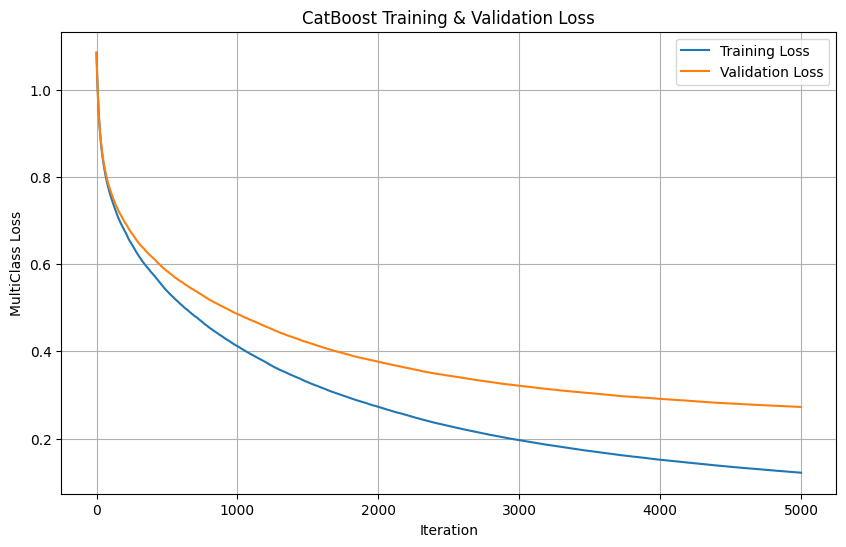

In [107]:
evals_result = model.get_evals_result()

train_loss = evals_result['learn']['MultiClass']
valid_loss = evals_result['validation']['MultiClass']

# Plot
plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('MultiClass Loss')
plt.title('CatBoost Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation

In [108]:
y_pred = model.predict(X_test)

### Confusion Matrix

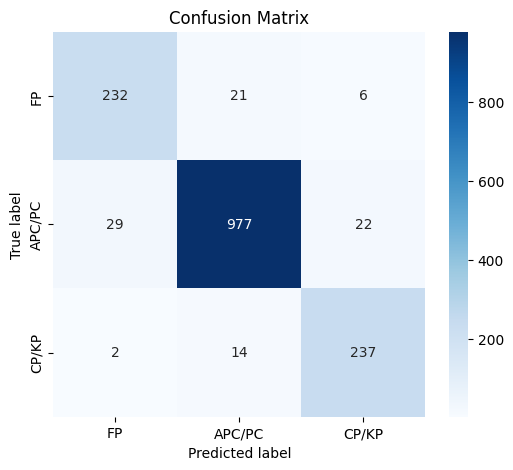

In [109]:
cm = confusion_matrix(y_test, y_pred)

class_names = ["FP", "APC/PC", "CP/KP"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

Accuracy

In [110]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

Accuracy: 93.90%


In [ ]:
model.save_model("TESS_Model.onnx", format="onnx")